In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from os import path
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
from wordcloud import ImageColorGenerator
import re
import pickle
import joblib
import spacy
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import numpy as np
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
import datetime
import warnings
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from bs4 import BeautifulSoup
from gensim.models import CoherenceModel
from gensim import corpora, models
# !pip install pyLDAvis Uncomment and run it if not installed
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package punkt to /home/rlb4/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rlb4/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
tweets = pd.read_csv("../data/train_data.csv", encoding="ISO-8859-1")
tweets = tweets.dropna(subset=['text'])
tweets = tweets.reset_index(drop=True)

In [3]:
tweets = tweets[tweets.airline_sentiment == 'negative']

In [5]:
stopwords_lda = pd.read_csv('../LDA/LDA_details/stopwords_lda.csv')

def preprocess(text):
    
    stopwords = set(STOPWORDS)
    
    # Appending new airline related stop-words
    stopwords.update([str(i).lower() for i in stopwords_lda.name]) 
    
    # Filter for mentions
    mentions_filter = re.compile(r'(?<=\@)(\w+)')
    
    # Filter for hash-tags
    hashtags_filter = re.compile(r'(?<=\#)(\w+)')
    
    # Filter for flights numbers
    flight_numbers = re.compile(r'(flt\d*)')
    
    # Finding all mentions
    all_mentions = mentions_filter.findall(text.lower())
    
    # Finding all hash-tags
    all_hashtag = hashtags_filter.findall(text.lower())
    
    # Finding all hash-tags
    all_flights = flight_numbers.findall(text.lower())
    
    word_lemmatize = WordNetLemmatizer()
    
    # Lemmetizing
    def lemm_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lemmatize.lemmatize(item,'v'))
        return lemmatized
    
    # De-emojify tweets to text
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    text = deEmojify(text)
    soup = BeautifulSoup(text)
    text = soup.get_text()
    
    # Removing punctuation
    punc_text = [x.lower() for x in text if x not in string.punctuation]
    text = "".join(punc_text)
    
    # Tokenize words
    word_tokens = nltk.word_tokenize(text)
    
    # Keeping the words with length between 4 and 15
    filtered_tokens = [x for x in word_tokens if len(x)>4 and len(x)<15]
    
    # Filter tokens
    tokens = lemm_tokens(filtered_tokens, word_lemmatize)
    all_tokens = [i for i in tokens if (i not in stopwords) and (i not in all_mentions) 
                  and (i not in all_hashtag) and (i not in all_flights) and (not i.isdigit())]
    
    return all_tokens

In [6]:
text = """@Jenny @Joe and @Susan we are all very dissapointing in your service with the LONG delays
            for flt15539 560948 #notdoingthisanymore #dontflythem in New York to Chicago"""
preprocess(text)

['dissapointing', 'service', 'delay']

In [12]:
tweets['token']=tweets['text'].astype("string").map(preprocess)

In [13]:
tweets = tweets.drop_duplicates(subset=['text'], keep='first')
tweets = tweets.reset_index(drop=True)

In [15]:
def remove_if_empty(df):
    empty_ids = df['token'].map(lambda i: len(i)) > 0
    idsToDelete = []
    for i in range(len(empty_ids)):
        if not empty_ids[i]:
            idsToDelete.append(i)
    for currentID in idsToDelete:
        df = df.drop(df[df.index == currentID].index[0])
    return df

print(tweets.shape)
tweets = remove_if_empty(tweets)
print(tweets.shape)

(9087, 16)
(8589, 16)


In [ ]:
tweets = tweets.reset_index(drop=True)

In [ ]:
processed_docs=tweets['token']
id2word = gensim.corpora.Dictionary(processed_docs)
corpus = [id2word.doc2bow(text) for text in processed_docs]

In [22]:
id2word.save_as_text('../LDA/LDA_details/dict.txt')
id2word.save('../LDA/LDA_details/id2word.dict')

In [23]:
def coherenceval(dictionary, corpus, texts, start, stop):
    c_val = []
    model_ls = []
    for num_topics in range(start, stop):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                num_topics=num_topics,
                                                id2word=id2word,
                                                random_state=123,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
        model_ls.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_val.append(coherencemodel.get_coherence())

    return model_ls, c_val

In [24]:
start=1
stop=15
model_list, coherence_values = coherenceval(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=processed_docs,
                                                        start=start, 
                                                        stop=stop)

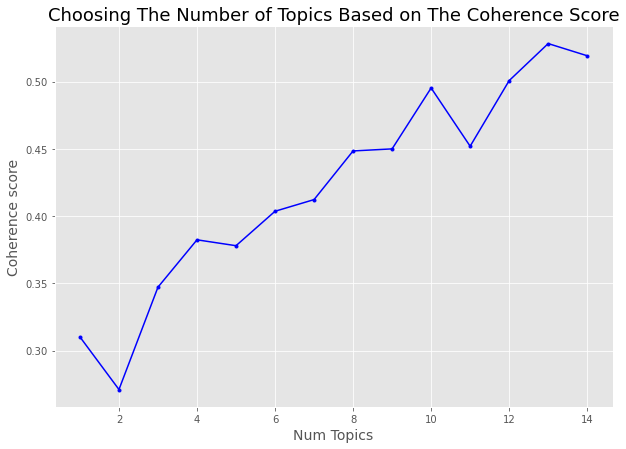

In [25]:
x = range(start, stop)
plt.figure(figsize=(10,7))
plt.style.use('ggplot')
plt.plot(x, coherence_values, color = "blue",marker=".")
plt.xlabel("Num Topics", size=14)
plt.ylabel("Coherence score", size=14)
plt.title('Choosing The Number of Topics Based on The Coherence Score',size=18)
plt.show()

In [26]:
%%time

# Build LDA model
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=8,
                                             alpha='auto',
                                             eta='auto',
                                             iterations=125,
                                             per_word_topics=True)

CPU times: user 1.01 s, sys: 11.3 ms, total: 1.02 s
Wall time: 1.01 s


In [27]:
from pprint import pprint
pprint(lda_model4.print_topics())

[(0,
  '0.045*"agent" + 0.036*"cancel" + 0.029*"board" + 0.027*"online" + '
  '0.019*"phone" + 0.019*"reservation" + 0.018*"time" + 0.015*"offer" + '
  '0.015*"wait" + 0.014*"travel"'),
 (1,
  '0.033*"baggage" + 0.020*"customer" + 0.019*"fly" + 0.018*"service" + '
  '0.016*"response" + 0.016*"respond" + 0.013*"experience" + 0.011*"change" + '
  '0.011*"issue" + 0.011*"address"'),
 (2,
  '0.037*"rebooked" + 0.037*"book" + 0.036*"agents" + 0.033*"change" + '
  '0.026*"check" + 0.025*"problems" + 0.016*"phone" + 0.015*"cater" + '
  '0.014*"ticket" + 0.014*"cancel"'),
 (3,
  '0.171*"cancel" + 0.033*"luggage" + 0.025*"rebook" + 0.018*"passengers" + '
  '0.017*"email" + 0.015*"ticket" + 0.014*"delay" + 0.013*"reason" + '
  '0.012*"airlines" + 0.011*"available"'),
 (4,
  '0.056*"phone" + 0.028*"answer" + 0.028*"reservations" + 0.027*"website" + '
  '0.016*"email" + 0.012*"message" + 0.012*"ticket" + 0.011*"switch" + '
  '0.011*"twice" + 0.011*"assistance"'),
 (5,
  '0.069*"wait" + 0.029*"tick

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model4.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model4, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.114195310933829

Coherence Score:  0.450014252105399


In [29]:
lda_model4.save('../LDA/LDA_details/lda_model4.model')

In [40]:
id2word = corpora.Dictionary.load('../LDA/LDA_details/id2word.dict')

#Test Tweets
unseen_document = "@united has the WORST customer experience ever! first the website was down, then the boarding and checkin processes w so complicated and slow"
# unseen_document = '@TK_HelpDesk @KuwaitAirports please see the thread. 11 passengers are stressed at your airport for 7 hours due to fight between 2 Airlines @KuwaitAirways @TurkishAirlines can you do something?? Humble request for a fast solution.'
# unseen_document = '''I didn't get my preferred seat. Was uncomfortable during the entire flight.'''
# unseen_document = '''the representative did not make any accommodation for the seconds  class ticket.'''
# unseen_document ='''Hi @airindia staff, i cancelled my ticket but no refund was provided please help'''

bow_vector = id2word.doc2bow(preprocess(unseen_document))
result = lda_model4.get_document_topics(bow_vector, minimum_probability=0.0)
resultdict = dict(result)

In [41]:
orddict = sorted(resultdict, key=resultdict.get, reverse=True)

Keymax = 1

if Keymax == 1:
    print('Delay Issue')
elif Keymax == 2:
    print('Reservation Issue')
elif Keymax == 3:
    print('Baggage Issue')
elif Keymax == 4:
    print('Customer Service')
elif Keymax == 5:
    print('Rescedule Issue')
elif Keymax == 6 or Keymax == 7:
    print('Phone or Online Booking Issue')
else:
    print('Refund Issues')
print("\n")

for index, score in resultdict.items():
    print("Score: {}\n Topic: {}\n Keywords:{} \n".format(score, index+1, lda_model4.print_topic(index)))

Predicted topic:  6
Probability Score:  0.39243674
Customer Experience


Score: 0.016110960394144058
 Topic: 1
 Keywords:0.045*"agent" + 0.036*"cancel" + 0.029*"board" + 0.027*"online" + 0.019*"phone" + 0.019*"reservation" + 0.018*"time" + 0.015*"offer" + 0.015*"wait" + 0.014*"travel" 

Score: 0.20095379650592804
 Topic: 2
 Keywords:0.033*"baggage" + 0.020*"customer" + 0.019*"fly" + 0.018*"service" + 0.016*"response" + 0.016*"respond" + 0.013*"experience" + 0.011*"change" + 0.011*"issue" + 0.011*"address" 

Score: 0.014000862836837769
 Topic: 3
 Keywords:0.037*"rebooked" + 0.037*"book" + 0.036*"agents" + 0.033*"change" + 0.026*"check" + 0.025*"problems" + 0.016*"phone" + 0.015*"cater" + 0.014*"ticket" + 0.014*"cancel" 

Score: 0.014952764846384525
 Topic: 4
 Keywords:0.171*"cancel" + 0.033*"luggage" + 0.025*"rebook" + 0.018*"passengers" + 0.017*"email" + 0.015*"ticket" + 0.014*"delay" + 0.013*"reason" + 0.012*"airlines" + 0.011*"available" 

Score: 0.09014085680246353
 Topic: 5
 Keywor

In [2]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model4, corpus, id2word,sort_topics=False)
pyLDAvis.save_html(vis, '../LDA/LDA_details/ldaviz.html')
vis

In [1]:
from IPython.display import HTML
HTML(filename='../LDA/LDA_details/ldaviz.html')